# Segregação do In em poços quânticos de $In_x Ga_{1-x} As$ sobre $GaAs$

Abaixo estão as bibliotecas e configurações utilizadas.

In [21]:
import warnings
warnings.filterwarnings('error')

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton

# constantes
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parâmetros Macro

In [2]:
N = 2048

## Funções para obtenção de níveis de energia

In [3]:
def fi(v, i):
    """
    short for flex_index, find the index i in array v
    i might be float, so that for i = 1.5, returns
    (v[2]+v[1])/2
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz    = z[1]-z[0]
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2)*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2)*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def fundamental(z, V, m):
    """
    finds the fundamental state under potential V for coordinate
    space z and effective mass m
    everything is expected to be in atomic units
    """
    
    dz  = z[1]-z[0]
    dz2 = dz**2
    
    # kick start function
    psi       = np.array(gaussian(N, std=int(N/100)), dtype=np.complex_)
    psi      /= np.sqrt(simps(psi.conj()*psi,z))
    
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i]
        except:
            main_diag[i] = 0.0
        
        if i < N-1:
            sub_diag[i] = -(0.5/dz2)*(1.0/fi(m,i+0.5))
    
    diagonals = [main_diag, sub_diag, sub_diag]
    A         = diags(diagonals, [0, -1, 1]).toarray()
    invA      = inv(A)
    
    counter   = 0
    precision = 1.0
    lastval   = 100.0
    eigenval  = 0.0
    
    while True:
        counter  += 1
        psi       = invA.dot(psi)
        #psi      /= np.sqrt(simps(psi.conj()*psi, z))
        eigenval  = eigenvalue(z, V, psi, m)
        precision = np.abs(1-eigenval/lastval)
        lastval   = eigenval
        
        if precision < 1e-8:
            break
        
    
    return {
        'eigenvalue': eigenval,
        'eigenvector': psi
    }

## Aplicação ao nível fundamental de um poço de $Al_x Ga_{1-x} As/GaAs$

Vamos aplicar as funções acima à um poço de $Al_x Ga_{1-x} As/GaAs$ com $x=0.0$ dentro do poço e $x=0.4$ nas barreiras e largura de $80$ Angstrom. A fórmula para o GAP a $0 K$ é dada por:

$$E_g (x) = 1.519+1.447x -0.15 x^2 \,\,\,\, (eV)$$

No caso:

$$E_g(0.0) = 1,519 \,\,\,\, (eV)$$
$$E_g(0.2) = 1,8024 \,\,\,\, (eV)$$

O GAP do Vamos escolher o *band offset* como $70\%$ da diferença de GAP para a banda de condução e $30\%$ para a banda de valência. Como na figura à seguir:

[]

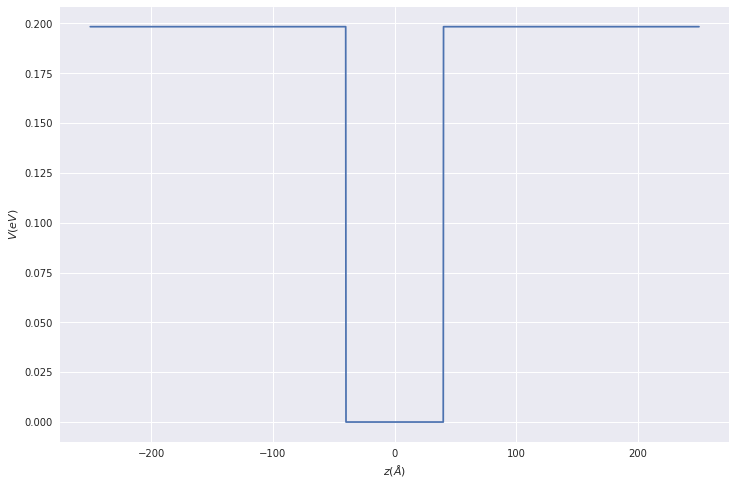

In [8]:
g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
m_algaas = lambda x: 0.067+0.083*x # effective mass
x_b      = 0.2 # barrier
x_w      = 0.0 # well
wl       = 80.0 # Angstrom
VBO      = 0.3
CBO      = 0.7
z_ang    = np.linspace(-250.0, 250.0, N) # Angstrom
v_shape  = lambda z: g_algaas(x_b) if np.abs(z) > wl/2 else g_algaas(x_w)
m_shape  = lambda z: m_algaas(x_b) if np.abs(z) > wl/2 else m_algaas(x_w)

# only conduction and set zero to well's bottom
V          = np.vectorize(v_shape)(z_ang)*CBO
V         -= np.min(V)

# efffective mass 
meff       = np.vectorize(m_shape)(z_ang)

plt.xlabel('$z (\AA)$')
plt.ylabel('$V (eV)$')
plt.plot(z_ang, V)
plt.plot()

Nosso potencial está em $eV$, vamos converter ele para unidades atômicas, fazendo o mesmo para o vetor de coordenadas.

In [9]:
V_au = V / au2ev
z_au = z_ang / au2ang

Vamos agora calcular o primeiro nível de energia

In [18]:
res = fundamental(z_au, V_au, meff)
value  = res['eigenvalue'] * au2ev # in eV

# change from au to ang
vector  = res['eigenvector']
vector /= np.sqrt(simps(vector.conj()*vector, z_ang))

print(r"E0 = %.4f eV" % value)

E0 = 0.0398 eV


A solução analítica para esse potencial pode ser obtida a para

$$
\tan \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = \sqrt{\frac{(V_b-E_n)}{E_n}} \\
\cot \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = -\sqrt{\frac{(V_b-E_n)}{E_n}}
$$

Onde $a=80$ Angstrom e $V_b=0.7 \times (E_g(0.2)-E_g(0.0))$. Para a solução analítica, adotamos $m_e^*$ como sendo a massa efetiva do elétron dentro do poço, ou seja, a massa efetiva do $GaAs$ ($0.067$).

In [26]:
m_eff = 0.067
wl_au = wl / au2ang
vb_au = np.ptp(V_au)

trans_tan = lambda e: np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) - np.sqrt(vb_au/e - 1.0)

trans_tan_der = lambda e: 1.0 / np.cos(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) + vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

trans_cot = lambda e: 1.0 / np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) + np.sqrt(vb_au/e - 1.0)

trans_cot_der = lambda e: -1.0 / np.sin(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) - vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

t_functions = [
    (trans_tan,trans_tan_der),
    (trans_cot, trans_cot_der)
]

# kickstart energies values
energies = np.linspace(-0.1*vb_au, 1.1*vb_au, 10000)
eigenvalues = []
for f,fp in t_functions:
    for e0 in energies:
        try:
            root = newton(f, x0=e0, fprime=fp)
            if root > 0:
                eigenvalues.append(root * au2ev)
        except:
            pass

eigenvalues = np.array(list(sorted(set(eigenvalues))))

# eigenvalues at this point is a huge list with almost
# 2000 elements, many of them almost the same, duo to 
# kickstart values leading to the same eigenvalue 
# the code bellow identifies the proper ranges and get the
# average of each, actually, the difference is only
# the numerical error, which is about 1e-11 eV for an 
# eigenvalue of order 0.01 eV
offset = [0]
for i in range(1, eigenvalues.size):
    if np.abs(eigenvalues[i] / \
            np.average(eigenvalues[offset[-1]:i])-1.0) > 0.01:
        offset.append(i)
offset.append(len(eigenvalues))
eigenvalues = [np.average(eigenvalues[offset[i]:offset[i+1]]) \
    for i in range(len(offset)-1)]

for i, eigen in enumerate(eigenvalues):
    print("E%d = %.4f eV" % (i, eigen))

E0 = 0.0423 eV
E1 = 0.1526 eV


Vemos que o primeiro autovalor analítico está em grande acordo com o valor obtido numericamente.

$$
\Delta \approx 0.0423 - 0.0398 = 0.0025 eV
$$

Vale lembrar ainda que enquanto o método numérico enxerga a massa efetiva diferente do lado de fora do poço, a solução analítica só vale para uma massa efetiva constante dentro e fora do poço.

## PL do $In_{0.14} Ga_{0.86} As$ sobre $GaAs$

Vamos agora passo a passo tentar reproduzir os valores obtidos experimentalmente.

Amostra crescida a 475 °C e PL medida a 77 K:

> ML=10, PL= 1.43681 eV

> ML=15, PL= 1.40565 ev

> ML=21, PL= 1.38018 eV

> ML=28, PL= 1.36112 eV

Amostra crescida a 525 °C e PL medida a 77 K:

> ML=10, PL= 1.45091 eV

> ML=15, PL= 1.42051 ev

> ML=21, PL= 1.39425 eV

> ML=28, PL= 1.37454 ev

Onde ML é abreviação de Monolayers (metade do parametro de rede).

Apenas para fins de comparação gradual:

In [30]:
samples = {
    'ml': [10, 15, 21, 28],
    475: [1.43681, 1.40565, 1.38018, 1.36112],
    525: [1.45091, 1.42051, 1.39425, 1.37454]
}

x0 = 0.14 # indended indium concentration

Vamos começar com um poço de $InGaAs$ simples. Sendo GAP do $In_x Ga_{1-x} As$ a $2$ K dado por:

$$
E_g (x) = 1.522-1.1 x +0.4 x^2 \,\,\,\, eV
$$

Além disso, as massas efetivas do elétron e do buraco pesado na direção de crescimento (respectivamente) são dadas por:

$$
1/ m_e (x) = x/0.023 + (1-x)/0.067   \\
1/ m_{hh_z} (x) = x/0.263 + (1-x)/0.333
$$

Por fim, o parâmetro de rede é dado por:

$$
a_0 (x) = 6.0584 x + 5.6533 (1-x)
$$

In [31]:
eg_2 = lambda x: 1.522-1.1*x+0.4*x**2
me   = lambda x: 1.0/(x/0.023+(1-x)/0.067)
mhh  = lambda x: 1.0/(x/0.263+(1-x)/0.333)
a0   = lambda x: 6.0584*x + 5.6533*(1-x)

Este potencial simplificado fica dado por:

In [32]:
m_ingaas = lambda x: 0.067+0.083*x # effective mass
x_b      = 0.0 # barrier
x_w      = 0.14 # well
VBO      = 0.3
CBO      = 0.7
z_ang    = np.linspace(-250.0, 250.0, N) # Angstrom
z_au     = z_ang / au2ang # atomic units
wl_lens  = [(a0(x0)/2.0) * nl for nl in samples['ml']]

for i, ml in enumerate(samples['ml']):
    wl = (a0(x0)/2.0) * ml
    v_shape   = lambda z: eg_2(x_b) if np.abs(z) > wl/2 else eg_2(x_w)
    me_shape  = lambda z: me(x_b) if np.abs(z) > wl/2 else me(x_w)
    mhh_shape = lambda z: mhh(x_b) if np.abs(z) > wl/2 else mhh(x_w)
    
    Vc        = np.vectorize(v_shape)(z_ang)*CBO
    Vv        = np.vectorize(v_shape)(z_ang)*VBO
    Vc_red    = Vc-np.min(Vc)
    Vv_red    = Vv-np.min(Vv)
    Vc_au     = Vc_red / au2ev
    Vv_au     = Vv_red / au2ev
    
    me_eff    = np.vectorize(me_shape)(z_ang)
    mhh_eff   = np.vectorize(mhh_shape)(z_ang)
  
    GAP       = np.min(Vc+Vv)
    res_e     = fundamental(z_au, Vc_au, me_eff)
    eigen_e   = res_e['eigenvalue'] * au2ev # in eV
    res_hh    = fundamental(z_au, Vv_au, me_eff)
    eigen_hh  = res_hh['eigenvalue'] * au2ev # in eV

    PL = GAP + eigen_e + eigen_hh
    
    print("ML = %d, PL (475) = %.4f, PL (525) = %.4f, PL_num = %.4f" % (ml, samples[475][i], samples[525][i], PL))

ML = 10, PL (475) = 1.4368, PL (525) = 1.4509, PL_num = 1.4919
ML = 15, PL (475) = 1.4057, PL (525) = 1.4205, PL_num = 1.4706
ML = 21, PL (475) = 1.3802, PL (525) = 1.3942, PL_num = 1.4507
ML = 28, PL (475) = 1.3611, PL (525) = 1.3745, PL_num = 1.4338


Apesar de os valores numéricos acima estarem bastante diferentes dos valores experimentais, é impressionante o quão próximos mesmo ignorando praticamente todos os efeitos que estão por vir na sequência.

## Efeitos de Segregação

Vamos começar a melhorar nosso modelo incluindo logo de cara a segregação.